In [13]:
# 1. Carga y unión de datos
import pandas as pd
import os

# Definir ruta base
base_path = r"D:\HP\Downloads\Ganancias de los eSports"

# Cargar archivos CSV
df_players = pd.read_csv(os.path.join(base_path, "highest_earning_players.csv"))
df_teams = pd.read_csv(os.path.join(base_path, "highest_earning_teams.csv"))
df_country_codes = pd.read_csv(os.path.join(base_path, "country-and-continent-codes-list.csv"))

print(df_players.head())
print(df_teams.head())
print(df_country_codes.head())


   PlayerId NameFirst   NameLast CurrentHandle CountryCode  TotalUSDPrize  \
0      3883     Peter  Rasmussen       dupreeh          dk     1822989.41   
1      3679   Andreas   Højsleth         Xyp9x          dk     1799288.57   
2      3885   Nicolai     Reedtz        dev1ce          dk     1787489.88   
3      3672     Lukas  Rossander        gla1ve          dk     1652350.75   
4     17800      Emil       Reif        Magisk          dk     1416448.64   

                               Game                 Genre  
0  Counter-Strike: Global Offensive  First-Person Shooter  
1  Counter-Strike: Global Offensive  First-Person Shooter  
2  Counter-Strike: Global Offensive  First-Person Shooter  
3  Counter-Strike: Global Offensive  First-Person Shooter  
4  Counter-Strike: Global Offensive  First-Person Shooter  
   TeamId             TeamName  TotalUSDPrize  TotalTournaments       Game  \
0     760  San Francisco Shock      3105000.0                 7  Overwatch   
1     776      London

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PlayerId       1000 non-null   int64  
 1   NameFirst      1000 non-null   object 
 2   NameLast       1000 non-null   object 
 3   CurrentHandle  1000 non-null   object 
 4   CountryCode    1000 non-null   object 
 5   TotalUSDPrize  1000 non-null   float64
 6   Game           1000 non-null   object 
 7   Genre          1000 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 62.6+ KB
None
           PlayerId  TotalUSDPrize
count   1000.000000   1.000000e+03
mean   27793.587000   3.977932e+05
std    22170.225194   6.908492e+05
min     1000.000000   2.417167e+04
25%     5374.500000   8.378962e+04
50%    23502.000000   1.683284e+05
75%    48127.250000   3.937352e+05
max    83085.000000   6.952597e+06
PlayerId         0
NameFirst        0
NameLast         0
CurrentHandle  

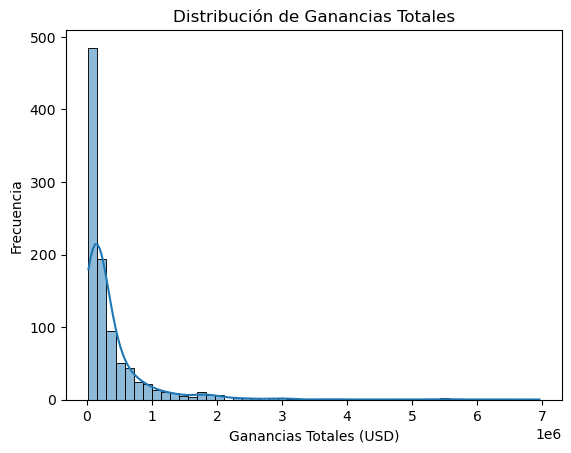

Valores únicos en Game: 10


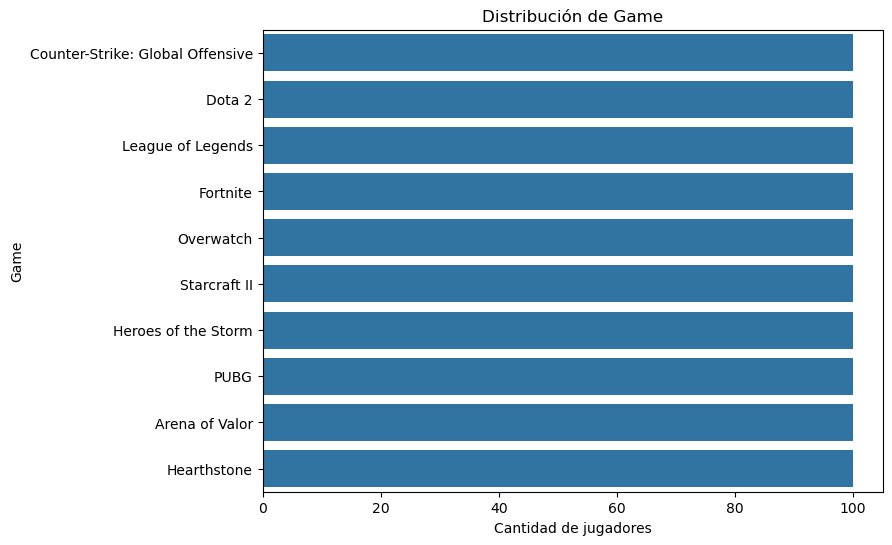

Valores únicos en Genre: 5


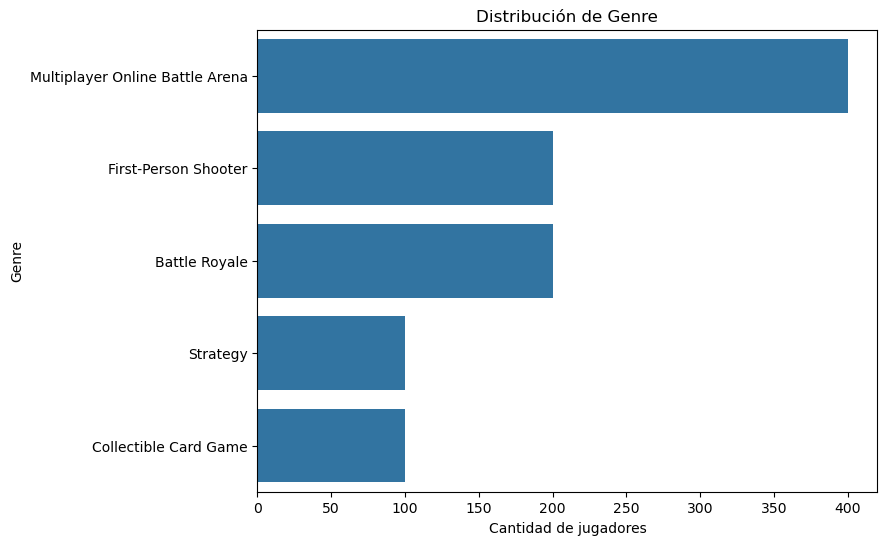

Valores únicos en CountryCode: 56


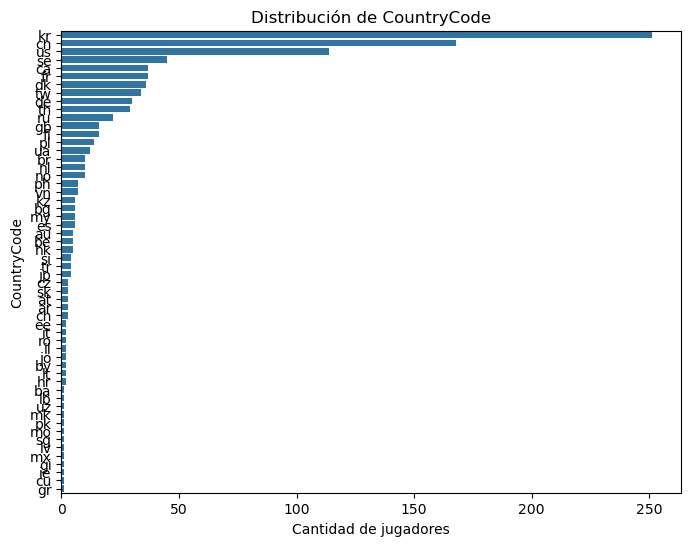

In [14]:
# 2. Análisis Exploratorio de Datos (EDA)

# Información general y tipos de datos
print(df_players.info())

print(df_players.describe())

print(df_players.isnull().sum())

import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de la variable objetivo
sns.histplot(df_players['TotalUSDPrize'], bins=50, kde=True)
plt.title("Distribución de Ganancias Totales")
plt.xlabel("Ganancias Totales (USD)")
plt.ylabel("Frecuencia")
plt.show()

# Análisis de variables categóricas
categorical_cols = ['Game', 'Genre', 'CountryCode']

for col in categorical_cols:
    print(f"Valores únicos en {col}: {df_players[col].nunique()}")
    plt.figure(figsize=(8,6))
    sns.countplot(y=df_players[col], order=df_players[col].value_counts().index)
    plt.title(f"Distribución de {col}")
    plt.xlabel("Cantidad de jugadores")
    plt.ylabel(col)
    plt.show()


In [15]:
#3. Feature Engineering y Selección

features = ['Game', 'Genre', 'CountryCode']
target = 'TotalUSDPrize'

df_encoded = pd.get_dummies(df_players[features], drop_first=True)

df_model = pd.concat([df_encoded, df_players[target]], axis=1)

print("DataFrame listo para el modelo:")
print(df_model.head())

DataFrame listo para el modelo:
   Game_Counter-Strike: Global Offensive  Game_Dota 2  Game_Fortnite  \
0                                   True        False          False   
1                                   True        False          False   
2                                   True        False          False   
3                                   True        False          False   
4                                   True        False          False   

   Game_Hearthstone  Game_Heroes of the Storm  Game_League of Legends  \
0             False                     False                   False   
1             False                     False                   False   
2             False                     False                   False   
3             False                     False                   False   
4             False                     False                   False   

   Game_Overwatch  Game_PUBG  Game_Starcraft II  Genre_Collectible Card Game  \
0           Fals

In [16]:
# 4. División de datos
from sklearn.model_selection import train_test_split

# Separar X (features) e y (target)
X = df_model.drop(columns=[target])
y = df_model[target]

# Dividir datos: 80% train, 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} registros")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} registros")


Tamaño del conjunto de entrenamiento: 800 registros
Tamaño del conjunto de prueba: 200 registros


In [17]:
# 5.1 Entrenar Decision Tree Regressor (Modelo Base)
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Crear modelo con límite de profundidad 
dt_model = DecisionTreeRegressor(random_state=42, max_depth=10)

# Entrenar con datos de entrenamiento
dt_model.fit(X_train, y_train)

# Predecir en test
y_pred_test = dt_model.predict(X_test)

print("--- Resultados del Decision Tree ---")
print(f"Error Cuadrático Medio (RMSE): ${np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
print(f"Coeficiente de Determinación (R2): {r2_score(y_test, y_pred_test):.4f}")

--- Resultados del Decision Tree ---
Error Cuadrático Medio (RMSE): $394241.62
Coeficiente de Determinación (R2): 0.6491


In [18]:
# 5.2 Entrenar Random Forest Regressor (Modelo Avanzado)
from sklearn.ensemble import RandomForestRegressor

# Inicializar el modelo.
rf_model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predecir en test
y_pred_test_rf = rf_model.predict(X_test)

print("\n--- Resultados del Random Forest ---")
print(f"Error Cuadrático Medio (RMSE): ${np.sqrt(mean_squared_error(y_test, y_pred_test_rf)):.2f}")
print(f"Coeficiente de Determinación (R2): {r2_score(y_test, y_pred_test_rf):.4f}")



--- Resultados del Random Forest ---
Error Cuadrático Medio (RMSE): $398781.26
Coeficiente de Determinación (R2): 0.6410


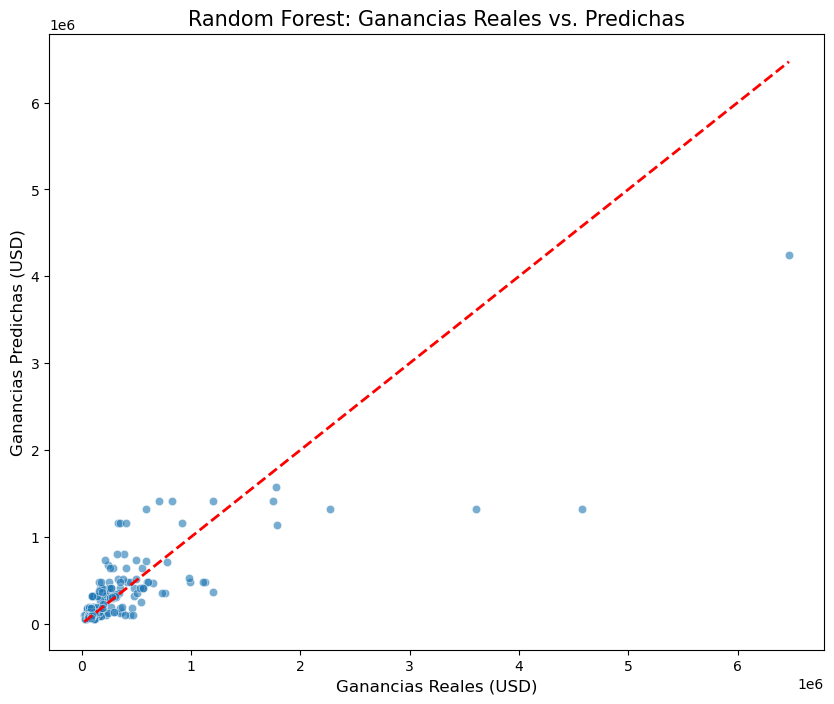

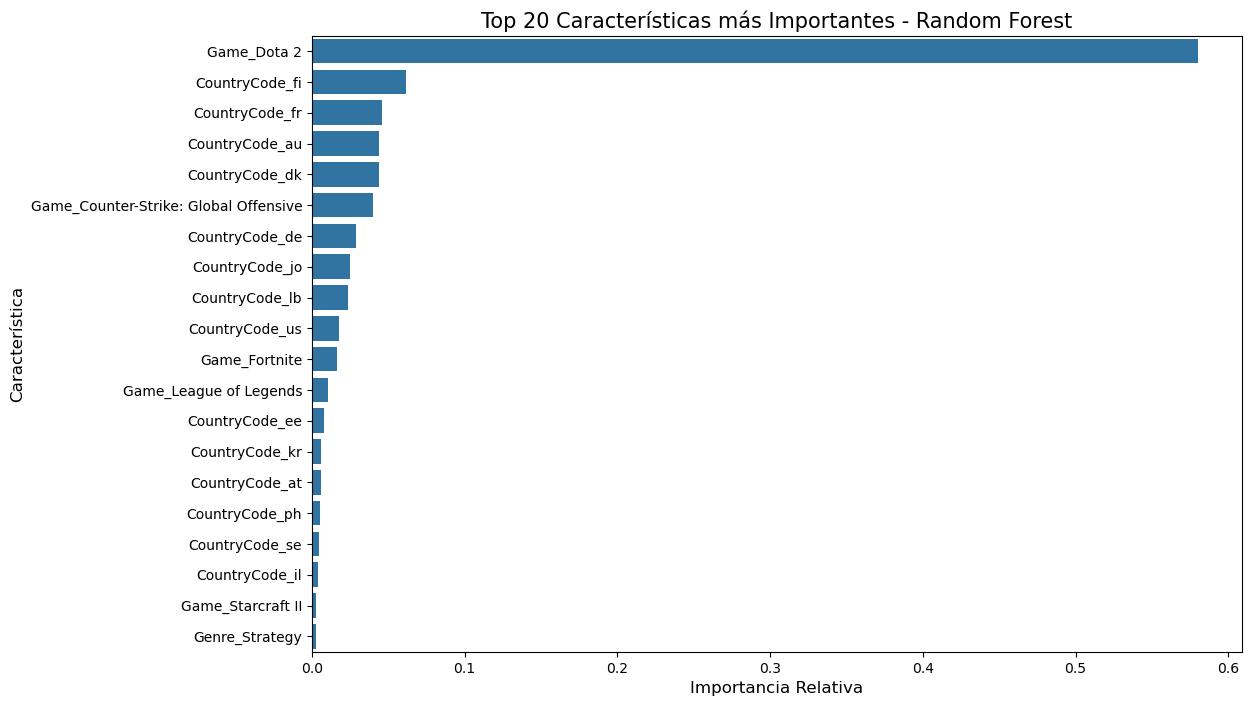

In [19]:
# 6. Visualización de resultados
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Gráfico 1: Comparar predicciones vs valores reales para Random Forest
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_test_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Random Forest: Ganancias Reales vs. Predichas", fontsize=15)
plt.xlabel("Ganancias Reales (USD)", fontsize=12)
plt.ylabel("Ganancias Predichas (USD)", fontsize=12)
plt.show()

# Gráfico 2: Importancia de características del Random Forest
importances = rf_model.feature_importances_
features_names = X.columns
feat_imp = pd.Series(importances, index=features_names).sort_values(ascending=False)
top_features = feat_imp.head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features, y=top_features.index)
plt.title("Top 20 Características más Importantes - Random Forest", fontsize=15)
plt.xlabel("Importancia Relativa", fontsize=12)
plt.ylabel("Característica", fontsize=12)
plt.show()

Se filtrarán para la visualización las ganancias reales superiores a: $1,110,703.71 USD


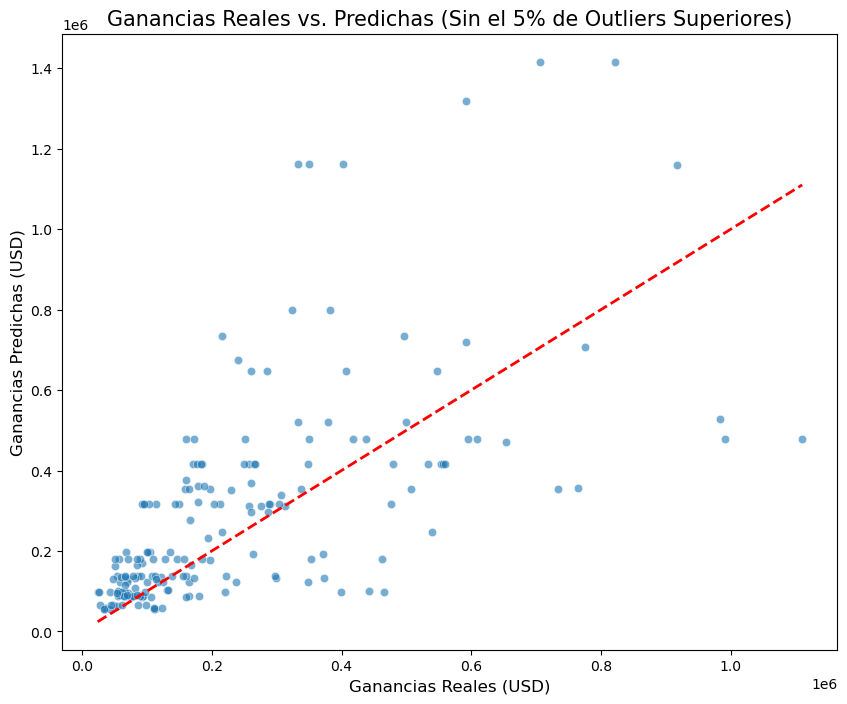

In [20]:
# 7. Visualización de Resultados sin Outliers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Crear DataFrame con valores reales y predichos
df_plot = pd.DataFrame({
    'Ganancias Reales': y_test,
    'Ganancias Predichas': y_pred_test_rf
})

# Definir umbral para outliers (percentil 95)
outlier_threshold = df_plot['Ganancias Reales'].quantile(0.95)
print(f"Se filtrarán para la visualización las ganancias reales superiores a: ${outlier_threshold:,.2f} USD")

# Filtrar outliers
df_filtered_plot = df_plot[df_plot['Ganancias Reales'] < outlier_threshold]

# Gráfico sin outliers
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Ganancias Reales',
    y='Ganancias Predichas',
    data=df_filtered_plot,
    alpha=0.6
)

# La línea de predicción perfecta se ajusta a los nuevos límites de los datos filtrados
plt.plot(
    [df_filtered_plot['Ganancias Reales'].min(), df_filtered_plot['Ganancias Reales'].max()],
    [df_filtered_plot['Ganancias Reales'].min(), df_filtered_plot['Ganancias Reales'].max()],
    'r--', lw=2
)

plt.title("Ganancias Reales vs. Predichas (Sin el 5% de Outliers Superiores)", fontsize=15)
plt.xlabel("Ganancias Reales (USD)", fontsize=12)
plt.ylabel("Ganancias Predichas (USD)", fontsize=12)
plt.show()